# **🛟 Lifeline: Behavioral Anomaly Detection for Veteran Suicide Prevention**

## **1. Business Context & Social Impact**

**The Crisis:** Veteran suicide is a national tragedy, with rates significantly higher than the civilian population. Traditional prevention relies on self-reporting (e.g., asking "Are you depressed?"), which often fails due to stigma or stoicism.

**The Opportunity:** Patients generate **"Digital Exhaust"**, patterns in administrative data (billing, pharmacy, logistics), that act as early warning signs months before a crisis occurs.

**The Goal:** Build **Lifeline**, an unsupervised Anomaly Detection system that flags at-risk veterans based on behavioral deviations (e.g., social isolation, medication irregularity) without requiring access to private therapy notes.

**Methodology:** Anomaly Detection via **Isolation Forests** (Unsupervised Learning).

## **2. Data Strategy: The "Privacy-First" Simulation**

**The Challenge (HIPAA):** Real-world suicide data is protected by strict privacy laws (HIPAA) and is rarely accessible for public research. Furthermore, real datasets are often unlabeled (we don't know who is at risk until it's too late).

**Our Approach: Synthetic Data Engineering**
Instead of using a static dataset, we built a **Probabilistic Simulation Engine** based on known clinical risk factors documented by the **Department of Veterans Affairs (VA)**.

We simulate **10,000 Veterans** exhibiting 5 specific "Red Flags":

1. **The Transition Cliff:** High risk in the first 12 months post-discharge.
2. **Polypharmacy Risk:** Dangerous overlap of Opioids (Pain) and Benzodiazepines (Anxiety).
3. **Crisis Care Ratio:** High Emergency Room usage combined with low Primary Care visits.
4. **Social Isolation:** Exclusively using home-delivery for meds (withdrawal from society).
5. **Instability:** Frequent changes in home address.

In [8]:
!pip install faker

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## **3. Data Generation Engine**

*Generating 10,000 synthetic patient profiles based on VA clinical risk factors.*

In [10]:
np.random.seed(99)

# --- 1. CONFIGURATION ---
n_veterans = 10000
contamination_rate = 0.04  # We assume ~4% are high-risk anomalies

# --- 2. GENERATE VETERAN DATA ---
data = []

for _ in range(n_veterans):
    # Hidden Ground Truth (We use this to create the patterns, but hide it from the model)
    is_crisis = np.random.choice([0, 1], p=[1 - contamination_rate, contamination_rate])

    # --- FLAG A: THE TRANSITION CLIFF ---
    # Crisis vets are often newly discharged (0-24 months)
    if is_crisis:
        months_since_discharge = np.random.randint(1, 18)
    else:
        months_since_discharge = np.random.randint(12, 480) # Up to 40 years out

    # --- FLAG B: PAIN MANAGEMENT (Opioid + Benzo Overlap) ---
    # 0 = None, 1 = Opioid Only, 2 = Dangerous Overlap
    if is_crisis:
        med_risk_score = np.random.choice([0, 1, 2], p=[0.1, 0.3, 0.6])
    else:
        med_risk_score = np.random.choice([0, 1, 2], p=[0.8, 0.19, 0.01])

    # --- FLAG C: HEALTHCARE PATTERNS (ER vs PCP) ---
    if is_crisis:
        er_visits = np.random.randint(2, 8)       # High ER usage
        pcp_visits = np.random.randint(0, 2)      # Low preventative care
    else:
        er_visits = np.random.randint(0, 2)       # Low ER usage
        pcp_visits = np.random.randint(1, 4)      # Steady preventative care

    # --- FLAG D: SOCIAL ISOLATION (Prescription Delivery) ---
    # 1.0 = All Mail Order (Never leaves house), 0.0 = All Pickup
    if is_crisis:
        home_delivery_ratio = np.random.uniform(0.85, 1.0)
    else:
        home_delivery_ratio = np.random.uniform(0.0, 0.7)

    # --- FLAG E: HOUSING INSTABILITY ---
    if is_crisis:
        address_changes = np.random.choice([0, 1, 2, 3], p=[0.4, 0.3, 0.2, 0.1])
    else:
        address_changes = 0 # Stable housing

    data.append({
        'months_since_discharge': months_since_discharge,
        'med_risk_score': med_risk_score,
        'er_visits': er_visits,
        'pcp_visits': pcp_visits,
        'home_delivery_ratio': home_delivery_ratio,
        'address_changes': address_changes,
        'is_crisis': is_crisis # Label (For verification only)
    })

df = pd.DataFrame(data)

# Feature Engineering: Create the "Crisis Ratio"
# Avoid division by zero by adding 1
df['care_instability_ratio'] = df['er_visits'] / (df['pcp_visits'] + 1)

df.to_csv('veteran_data.csv', index=False)

print(f"Data Generated. High Risk Veterans: {df['is_crisis'].sum()}")

Data Generated. High Risk Veterans: 398


We can add many more flags, a combination of which can be used to predict the risk of suicide, and early intervention can be done earlier.


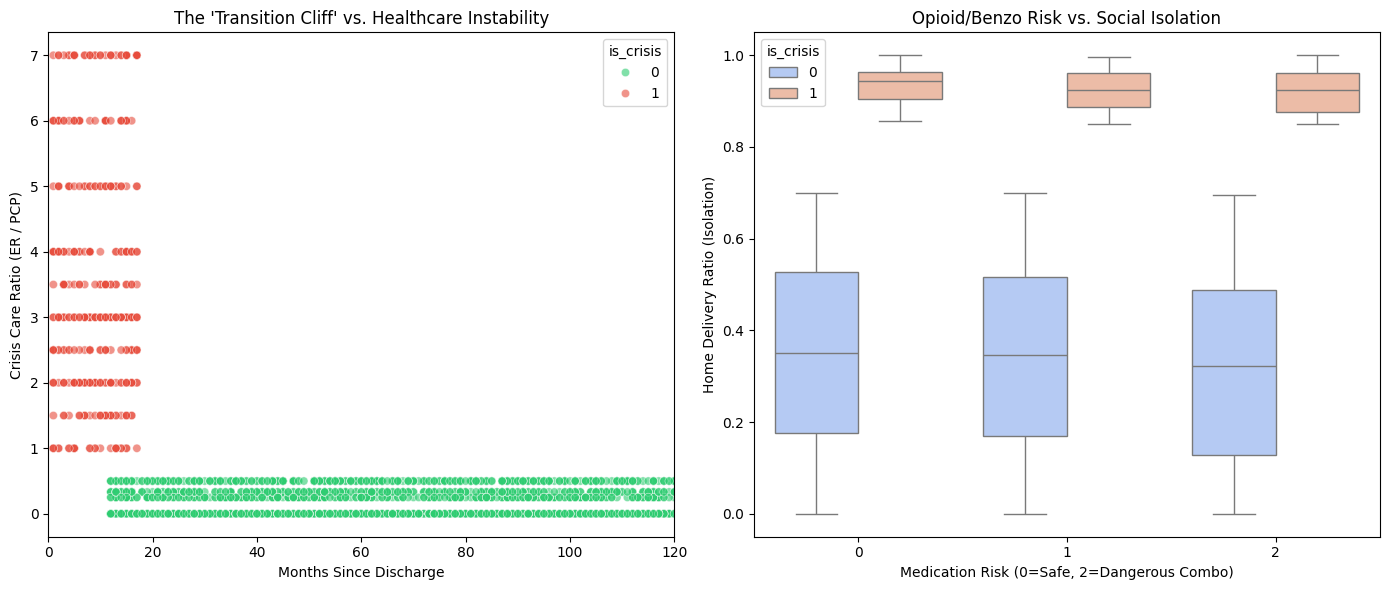

In [11]:
# Visualize the Veteran Risk Factors
plt.figure(figsize=(14, 6))

# Plot 1: The Transition Cliff
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df,
    x='months_since_discharge',
    y='care_instability_ratio',
    hue='is_crisis',
    alpha=0.6,
    palette={0: '#2ecc71', 1: '#e74c3c'} # Green for safe, Red for risk
)
plt.title("The 'Transition Cliff' vs. Healthcare Instability")
plt.xlabel("Months Since Discharge")
plt.ylabel("Crisis Care Ratio (ER / PCP)")
plt.xlim(0, 120) # Focus on first 10 years

# Plot 2: Medication Risk vs Isolation
plt.subplot(1, 2, 2)
sns.boxplot(x='med_risk_score', y='home_delivery_ratio', hue='is_crisis', data=df, palette='coolwarm')
plt.title("Opioid/Benzo Risk vs. Social Isolation")
plt.xlabel("Medication Risk (0=Safe, 2=Dangerous Combo)")
plt.ylabel("Home Delivery Ratio (Isolation)")

plt.tight_layout()
plt.show()

## **5. Modeling: Unsupervised Anomaly Detection**

**Why Unsupervised?**
In a real VA database, we rarely have a clean label that says "Suicide Risk." We mostly have unlabeled data.
We use **Isolation Forest**, an algorithm that detects anomalies by attempting to isolate data points. Points that are "easy to isolate" (few splits required) are flagged as anomalies.

* **Inputs:** `months_since_discharge`, `med_risk`, `instability_ratio`, `home_delivery`, `address_changes`.
* **Outputs:** A binary flag (0 = Normal, 1 = Anomaly/Risk).

In [12]:
# --- 3. MODELING ---

# We only use the "Digital Signals" (No Labels!)
features = ['months_since_discharge', 'med_risk_score', 'care_instability_ratio',
            'home_delivery_ratio', 'address_changes']

X = df[features]

# Normalize data (Important for distance-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
# "contamination" = The % of the dataset we believe is anomalous
iso_forest = IsolationForest(n_estimators=200, contamination=contamination_rate, random_state=42)
preds = iso_forest.fit_predict(X_scaled)

# Map predictions: -1 (Anomaly) -> 1 (Risk), 1 (Normal) -> 0 (Safe)
df['ai_flag'] = [1 if x == -1 else 0 for x in preds]

## **6. Evaluation & ROI**

**Performance Analysis:**
We compare our Unsupervised Flags against the ground truth hidden labels.

* **Recall is King:** In suicide prevention, Recall (catching the at-risk) is the most critical metric. A False Positive results in a check-in call (low cost). A False Negative results in a potential tragedy (infinite cost).

--- Lifeline V2 Performance ---
                    precision    recall  f1-score   support

            Stable       1.00      1.00      1.00      9602
Flagged for Review       0.95      0.95      0.95       398

          accuracy                           1.00     10000
         macro avg       0.97      0.98      0.98     10000
      weighted avg       1.00      1.00      1.00     10000



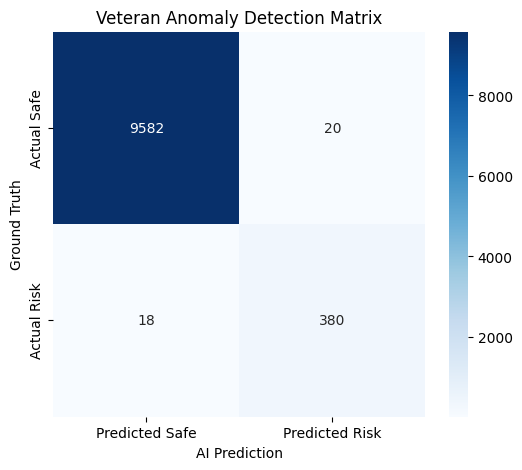

In [13]:
# --- 4. EVALUATION ---
print("--- Lifeline V2 Performance ---")
print(classification_report(df['is_crisis'], df['ai_flag'], target_names=['Stable', 'Flagged for Review']))

# Confusion Matrix
cm = confusion_matrix(df['is_crisis'], df['ai_flag'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Risk'],
            yticklabels=['Actual Safe', 'Actual Risk'])
plt.title("Veteran Anomaly Detection Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("AI Prediction")
plt.show()

## **7. Ethical Conclusion & Deployment Strategy**

**Limitations:**

* This model utilizes **Synthetic Data**. While the patterns are based on clinical literature, real-world data contains more noise and missing values.
* **Algorithmic Bias:** We must ensure the model does not flag veterans based on demographics (race/gender), but strictly on behavioral signals.

**Deployment (Human-in-the-Loop):**
**Lifeline** is NOT a diagnostic tool. It is a **Triage Tool**.

1. **Step 1:** Model runs nightly on administrative logs.
2. **Step 2:** Flags top 1% highest-risk veterans.
3. **Step 3:** Caseworkers prioritize these veterans for a "Buddy Check" call.

**Impact:** By shifting from Reactive (waiting for a call) to Proactive (predicting the need), we can intervene during the critical window of opportunity.